In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("data/ab_data.csv")

In [3]:
df.head(1)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0


In [4]:
df = df.drop_duplicates(subset=["user_id"], keep="first")

In [5]:
import numpy as np
import scipy.stats as stats
import statsmodels.stats.api as sms

In [6]:
effect_size = sms.proportion_effectsize(.13, .15)

In [7]:
required_n = sms.NormalIndPower().solve_power(
effect_size,
power= .8,
alpha = 0.05,
ratio = 1)

required_n

4719.4740575998185

round up to whole number

In [8]:
required_n = 4720

In [9]:
pd.crosstab(df["group"], df["landing_page"])

landing_page,new_page,old_page
group,,
control,1006,144226
treatment,144314,1038


In [10]:
control_sample = df[df["group"] == "control"].sample(n=required_n, random_state=13)

In [11]:
treatment_sample = df[df["group"] == "treatment"].sample(n=required_n, random_state=13)

In [12]:
df_ab = pd.concat([control_sample, treatment_sample])

In [13]:
df_ab

,user_id,timestamp,group,landing_page,converted
243468,936205,2017-01-17 12:34:24.590764,control,old_page,0
265368,749467,2017-01-12 21:24:28.532832,control,old_page,0
238767,934094,2017-01-03 16:04:48.085814,control,old_page,0
5185,859453,2017-01-21 08:32:34.377626,control,old_page,0
277111,785727,2017-01-14 07:05:23.100495,control,old_page,0
...,...,...,...,...,...
235211,637395,2017-01-07 03:43:54.097013,treatment,new_page,1
27977,639267,2017-01-04 16:35:33.523475,treatment,new_page,0
203197,910164,2017-01-13 03:41:20.616648,treatment,new_page,0
120934,861033,2017-01-12 09:09:03.276255,treatment,new_page,0


In [14]:
df_ab.reset_index(drop=True, inplace=True)

In [15]:
df_ab

,user_id,timestamp,group,landing_page,converted
0,936205,2017-01-17 12:34:24.590764,control,old_page,0
1,749467,2017-01-12 21:24:28.532832,control,old_page,0
2,934094,2017-01-03 16:04:48.085814,control,old_page,0
3,859453,2017-01-21 08:32:34.377626,control,old_page,0
4,785727,2017-01-14 07:05:23.100495,control,old_page,0
...,...,...,...,...,...
9435,637395,2017-01-07 03:43:54.097013,treatment,new_page,1
9436,639267,2017-01-04 16:35:33.523475,treatment,new_page,0
9437,910164,2017-01-13 03:41:20.616648,treatment,new_page,0
9438,861033,2017-01-12 09:09:03.276255,treatment,new_page,0


In [16]:
df_ab["group"].value_counts()

treatment    4720
control      4720
Name: group, dtype: int64

In [17]:
conversion_rate = df_ab.groupby("group")["converted"]

In [18]:
std_p = lambda x: np.std(x, ddof=0)

In [19]:
se_p = lambda x: stats.sem(x, ddof=0)

In [20]:
conversion_rate = conversion_rate.agg([np.mean, std_p, se_p])

In [21]:
conversion_rate.columns = ["convers_rate", "std_dev", "std_err"]

In [22]:
conversion_rate.style.format("{:.3f}")

,convers_rate,std_dev,std_err
group,,,
control,0.113,0.317,0.005
treatment,0.125,0.331,0.005


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

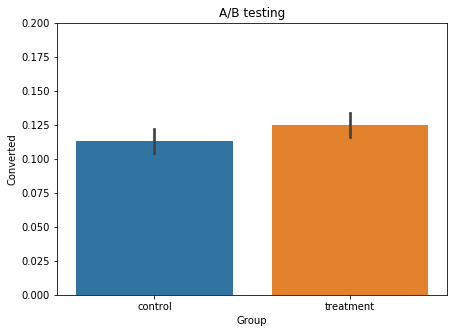

In [24]:
plt.figure(figsize=(7,5))

sns.barplot(x=df_ab["group"], y=df_ab["converted"])

plt.ylim(0,0.20)
plt.title("A/B testing")
plt.xlabel("Group")
plt.ylabel("Converted");

In [25]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [26]:
control_result = df_ab[df_ab["group"] == "control"]["converted"]

In [27]:
treatment_result = df_ab[df_ab["group"] == "treatment"]["converted"]

In [28]:
n_con = control_result.count()
n_treat = treatment_result.count()

In [29]:
success = [control_result.sum(), treatment_result.sum()]

In [30]:
nobs = [n_con, n_treat]

In [31]:
z_stat, pval = proportions_ztest(success, nobs=nobs)
(lower_con, lower_treat),(upper_con, upper_treat) = proportion_confint(success, nobs=nobs, alpha=.05)

In [32]:
print(f"z stats: {z_stat:.2f}")
print(f"p-value: {pval:.3f}")
print(f"CI 95% for control group: [{lower_con:.3f}. {upper_con:.3f}]")
print(f"CI 95% for treatment group: [{lower_treat:.3f}. {upper_treat:.3f}]")

z stats: -1.81
p-value: 0.070
CI 95% for control group: [0.104. 0.122]
CI 95% for treatment group: [0.116. 0.135]


p-value of 0.07 > 0.05

Cannot reject null hypothesis:

=> our new design did not perform significantlly different than our old one